In [1]:

import gym
import d4rl

env_name = "antmaze-large-diverse-v2"
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
print('state_dim:', state_dim, 'action_dim:', action_dim, 'max_action:', max_action)
data = d4rl.qlearning_dataset(env)

No module named 'flow'
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
libEGL warning: Not allowed to force software rendering when API explicitly selects a hardware device.
No module named 'carla'
pybullet build time: May 20 2022 19:45:31
/home/m_bobrin/anaconda3/envs/icvf/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.24069696176507, 25.277749508237182)
state_dim: 29 action_dim: 8 max_action: 1.0


load datafile: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.29it/s]


In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("..")

import os
os.environ['D4RL_SUPPRESS_IMPORT_ERROR'] = '1'

import gym
import d4rl

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib import patches

import equinox as eqx
import jax
import jax.numpy as jnp
import functools

from tqdm.auto import tqdm
from jaxrl_m.common import TrainStateEQX
from src.agents.iql_equinox import GaussianPolicy, GaussianIntentPolicy

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn
from ott.tools import plot, sinkhorn_divergence
from ott.solvers.linear import implicit_differentiation as imp_diff

import optax

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_psi(ensemble, s):
    return eqx.filter_vmap(ensemble.psi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None))
def eval_ensemble_phi(ensemble, s):
    return eqx.filter_vmap(ensemble.phi_net)(s)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None))
def eval_ensemble_icvf_viz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf_initial)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g, z), g - dim 29, z - dim 256
def eval_ensemble_icvf_latent_z(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.classic_icvf)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, g=None, z=None)) # V(s, g ,z ), g, z - dim 256
def eval_ensemble_icvf_latent_zz(ensemble, s, g, z):
    return eqx.filter_vmap(ensemble.icvf_zz)(s, g, z)

@eqx.filter_vmap(in_axes=dict(ensemble=eqx.if_array(0), s=None, z=None)) 
def eval_ensemble_gotil(ensemble, s, z):
    return eqx.filter_vmap(ensemble.gotil)(s, z)

@eqx.filter_jit
def get_gcvalue(agent, s, g, z):
    v_sgz_1, v_sgz_2 = eval_ensemble_icvf_viz(agent.value_learner.model, s, g, z)
    return (v_sgz_1 + v_sgz_2) / 2

def get_v_gz(agent, initial_state, target_goal, observations):
    initial_state = jnp.tile(initial_state, (observations.shape[0], 1))
    target_goal = jnp.tile(target_goal, (observations.shape[0], 1))
    return -1 * get_gcvalue(agent, initial_state, observations, target_goal)
    
def get_v_zz(agent, goal, observations):
    goal = jnp.tile(goal, (observations.shape[0], 1))
    return get_gcvalue(agent, observations, goal, goal)

@eqx.filter_vmap(in_axes=dict(agent=None, obs=None, goal=0))
def get_v_zz_heatmap(agent, obs, goal): # goal - whole traj
    goal = jnp.tile(goal, (obs.shape[0], 1))
    return get_gcvalue(agent, obs, goal, goal)

%matplotlib inline
%load_ext autoreload
%autoreload 2

%cd ..
from src.agents import icvf
icvf_model = icvf.create_eqx_learner(seed=42,
                                     observations=data['observations'][0],
                                     hidden_dims=[256, 256],
                                     pretrained_folder="antmaze-large-diverse",
                                     load_pretrained_icvf=True)

/home/m_bobrin/AILOT
Extra kwargs: {}


In [34]:
import plotly.express as px
from sklearn.decomposition import PCA

traj1 = data['observations'][155000:156000]
traj2 = data['observations'][44000:45000]

np_z1 = eval_ensemble_phi(icvf_model.value_learner.model, traj1).mean(0)
np_z2 = eval_ensemble_psi(icvf_model.value_learner.model, traj2).mean(0)
np_z3 = eval_ensemble_phi(icvf_model.value_learner.model, data['observations'][35000:36000]).mean(0)

pca1 = PCA(n_components=2)
components1 = pca1.fit_transform(np_z1)

pca2 = PCA(n_components=2)
components2 = pca2.fit_transform(np_z2)

pca3 = PCA(n_components=2)
components3 = pca3.fit_transform(np_z3)

In [35]:
jnp.linalg.norm(eval_ensemble_psi(icvf_model.value_learner.model, traj1[150][None]).mean(0) - eval_ensemble_psi(icvf_model.value_learner.model, traj1[170][None]).mean(0))

Array(0.8408979, dtype=float32)

In [36]:
dummy_npz1_act = eval_ensemble_phi(icvf_model.value_learner.model, traj1).mean(0) + np.random.randn(1000, 256)
pca_dummy = PCA(n_components=2)
components_dummy = pca_dummy.fit_transform(dummy_npz1_act)

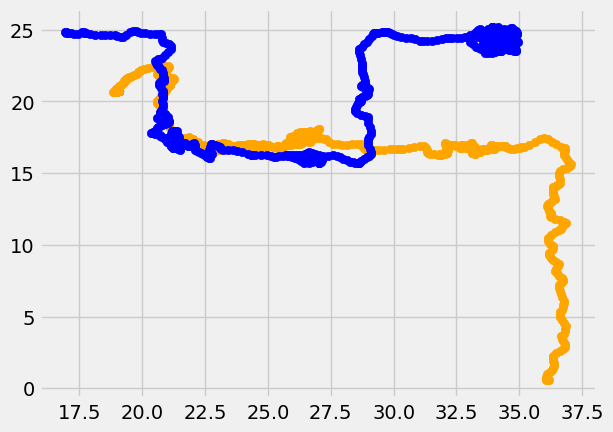

In [37]:
fig, ax = plt.subplots()
plt.scatter(traj1[:, 0], traj1[:, 1], color='orange')
plt.scatter(traj2[:, 0], traj2[:, 1], color='blue')

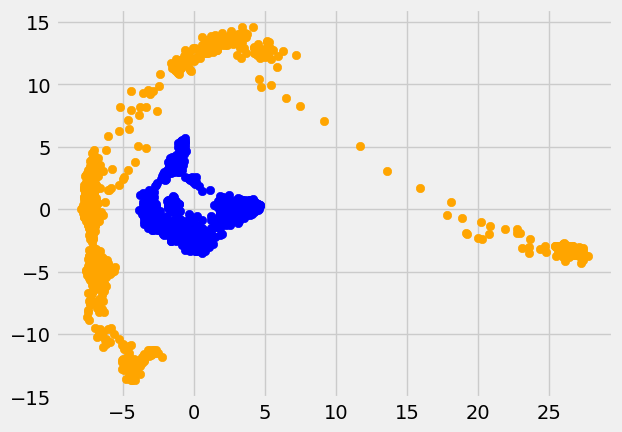

In [38]:
fig, ax = plt.subplots()
plt.scatter(components1[:, 0], components1[:, 1], color='orange')
plt.scatter(components2[:, 0], components2[:, 1], color='blue')
#plt.scatter(components_dummy[:, 0], components_dummy[:, 1], color='red')
#plt.scatter(components4[:, 0], components4[:, 1], color='green')

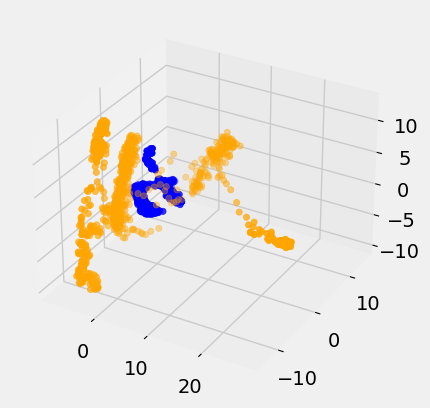

In [39]:
fig = plt.figure()
ax = plt.axes(projection='3d')

pca1 = PCA(n_components=3)
components1 = pca1.fit_transform(np_z1)
pca2 = PCA(n_components=3)
components2 = pca2.fit_transform(np_z2)

ax.scatter3D(components1[:, 0], components1[:, 1], components1[:, 2], color='orange')
ax.scatter3D(components2[:, 0], components2[:, 1], components2[:, 2], color='blue')
#ax.scatter3D(components_dummy[:, 0], components_dummy[:, 1], components_dummy[:, 2], color='purple', alpha=0.2)
#ax.scatter3D(components3[:, 0], components3[:, 1], components3[:, 2], color='red')

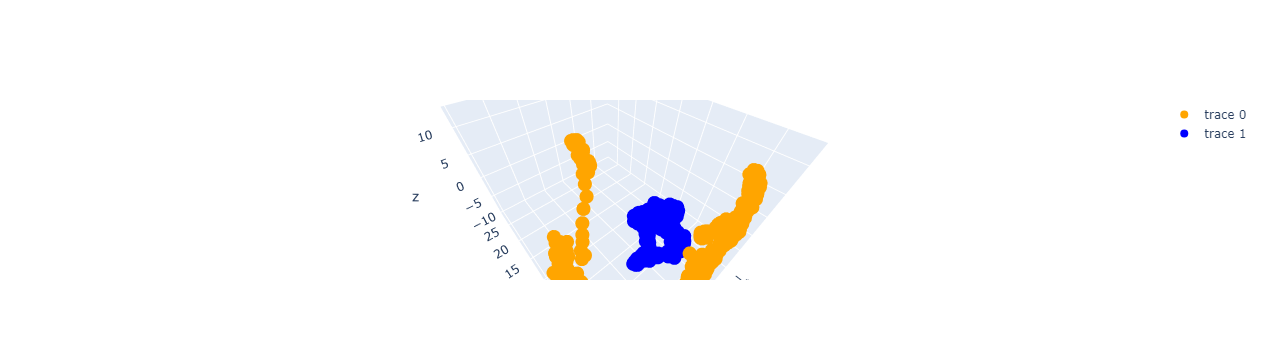

In [40]:
import plotly.graph_objects as go
import numpy as np
fig = go.Figure(data=[go.Scatter3d(x=components1[:, 0], y=components1[:, 1], z=components1[:, 2],
                                   mode='markers', marker={'color':'orange'})])

fig.add_trace(go.Scatter3d(x=components2[:, 0], y=components2[:, 1], z=components2[:, 2],
                                   mode='markers', marker={'color':'blue'}))
fig.show()